# SARIMA Multivariate application to a time series problem

**Notebook made by: André Reis & Gonçalo Freitas, University of Aveiro ©**

References : 

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys
from matplotlib import pyplot
from keras.layers import Bidirectional

#from read_files import read_files

import matplotlib.pyplot as plt

p = 1

# Setup variables

In [2]:
if p == 1:
    path = "D:/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
if p == 0:
    path = "C:/Users/OMEN/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
product_group_id = 958
time_series_folder = 1 #1,2,3

product_information = pd.read_pickle(path+"Data/product_information")
print(product_information.loc[product_group_id])

empresa = "Ripley"    # company we gonna study

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object


# Get data

In [3]:
df_long = pd.read_pickle(path+"Data/time_series_"+str(time_series_folder)+"/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

**Data Overview**

<Figure size 640x480 with 0 Axes>

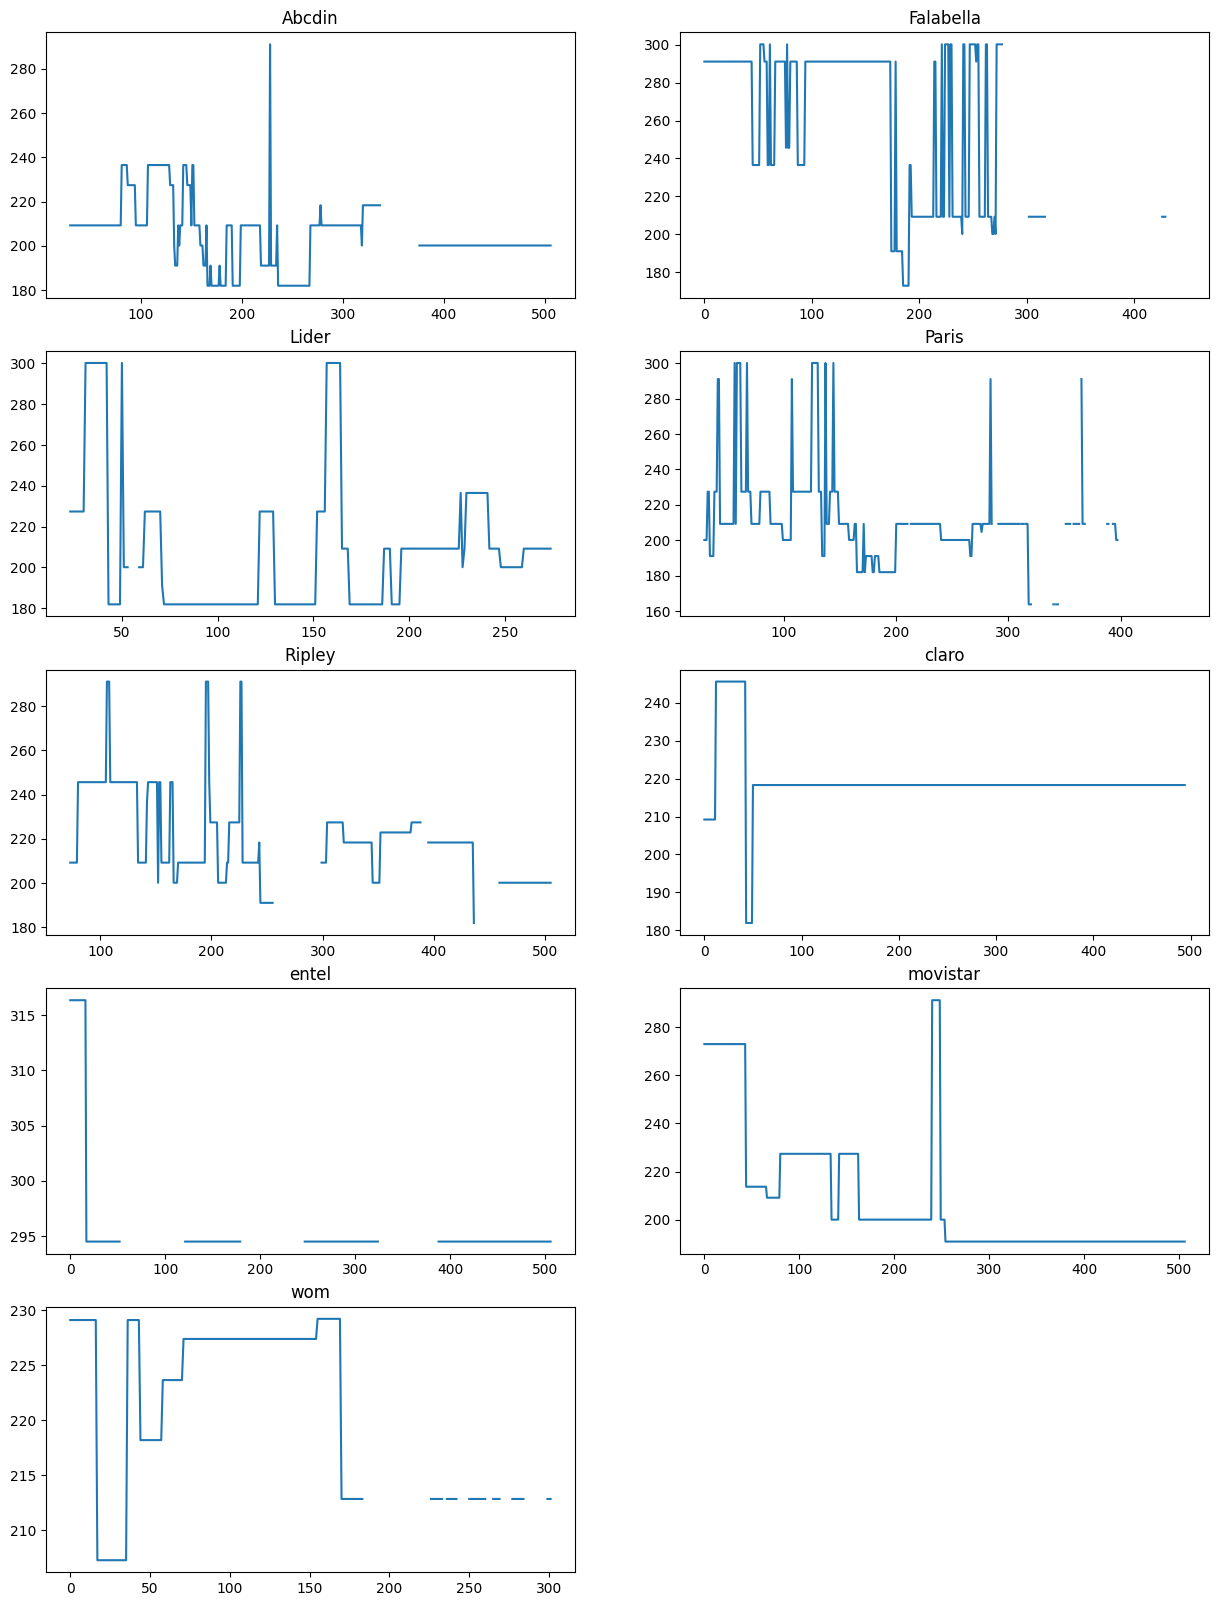

In [4]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,20))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

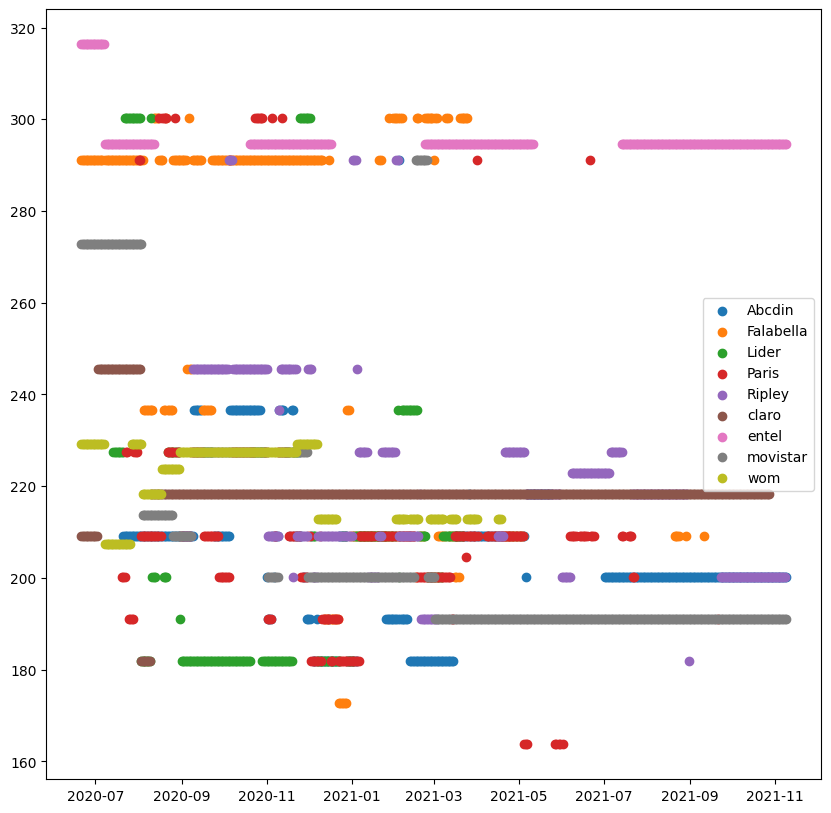

In [5]:
plt.figure(figsize=(10, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)

plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

**Interpolate to fix the NaN values and substitute them with a estimation of the value in that time**

In [6]:
"""
df_wide = df_wide.fillna(df_wide.mean())
"""
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")
print(df_wide)

                Abcdin   Falabella       Lider       Paris      Ripley  \
2020-06-21  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-22  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-23  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-24  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-25  209.214955  291.085236  227.408351  200.118257  209.214955   
...                ...         ...         ...         ...         ...   
2021-11-05  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-06  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-07  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-08  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-09  200.118257  209.214955  209.214955  191.021559  200.118257   

                 claro       entel    movistar         wom  
2020-06-21  209.214955  316.346766  272.891840  22

**Data overview after interpolation**

<Figure size 640x480 with 0 Axes>

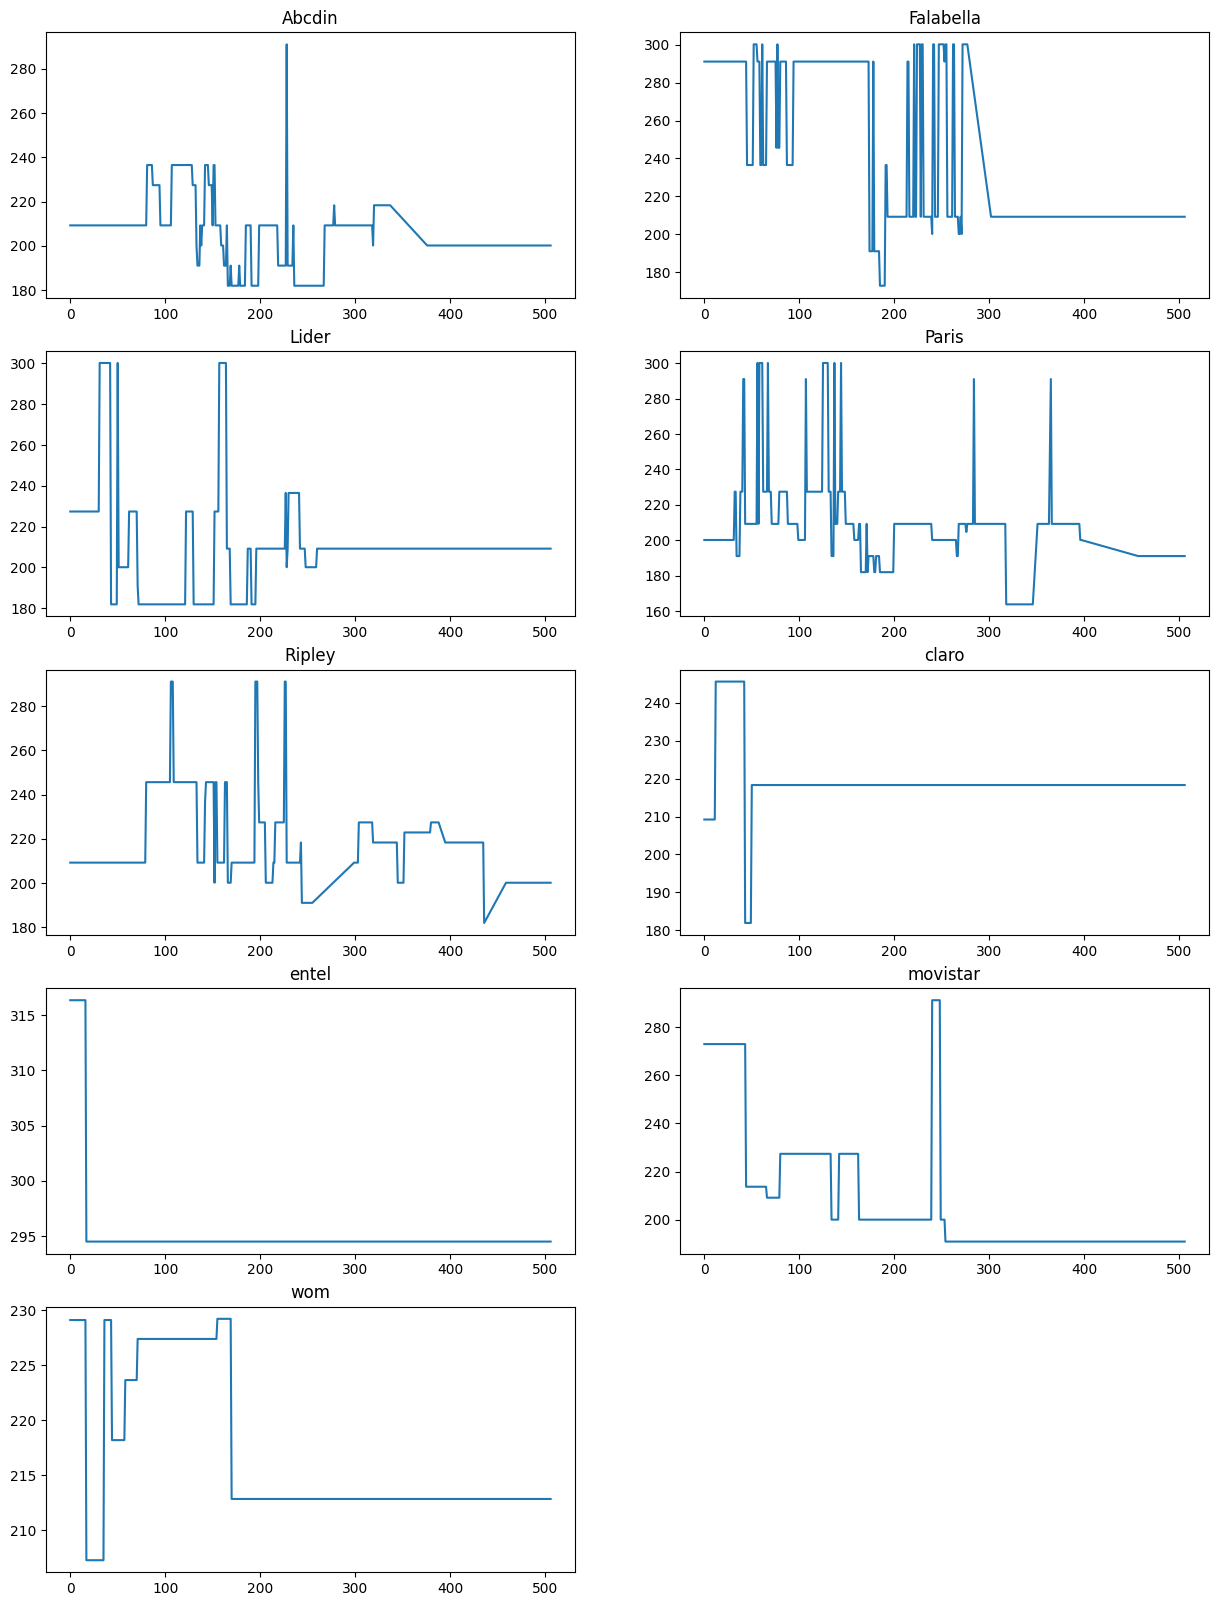

In [7]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,20))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

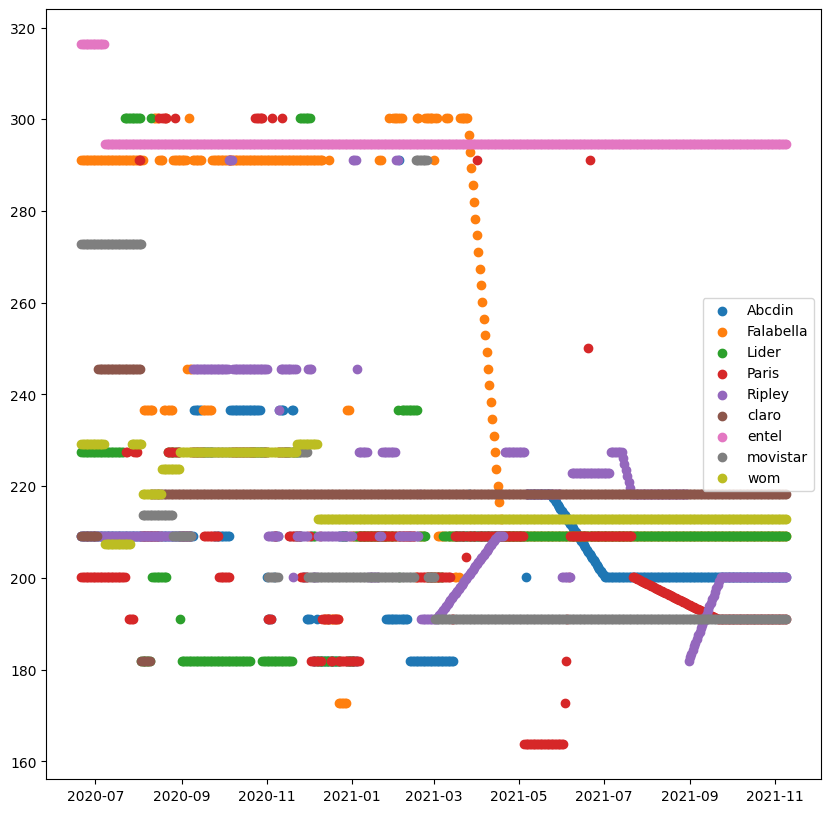

In [8]:
plt.figure(figsize=(10, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)

plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

# Sarima


Let´s Grid Search SARIMA Model Hyperparameters. Result with seed = 7 was [(3, 1, 0), (0, 0, 0, 0), 'n']

In [9]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import math

X = df_wide[empresa]

split_perc = 0.60
split = math.ceil(len(X)*split_perc)

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_mape(actual, predicted):
	return mean_absolute_percentage_error(actual, predicted)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	test = X[split:]
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_mape(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(lag_i, lag_f):
	models = list()
	# define config lists
	p_params = [x for x in range(lag_i,lag_f+1)]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = [0]
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	train, test = X[:split], X[split:]
	# model configs
	lag_i = 3
	lag_f = 20
	cfg_list = sarima_configs(lag_i, lag_f)
	n_test = len(test)
	# grid search
	scores = grid_search(train, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[(3, 0, 0), (0, 0, 0, 0), 'n']] 0.004
 > Model[[(3, 0, 0), (0, 0, 0, 0), 'c']] 0.008
 > Model[[(3, 0, 0), (0, 0, 0, 0), 't']] 0.004
 > Model[[(3, 0, 0), (0, 0, 0, 0), 'ct']] 0.007
 > Model[[(3, 0, 1), (0, 0, 0, 0), 'n']] 981031.083
 > Model[[(3, 0, 1), (0, 0, 0, 0), 'c']] 0.008
 > Model[[(3, 0, 1), (0, 0, 0, 0), 't']] 0.007
 > Model[[(3, 0, 1), (0, 0, 0, 0), 'ct']] 0.008
 > Model[[(3, 0, 2), (0, 0, 0, 0), 'n']] 0.006
 > Model[[(3, 0, 2), (0, 0, 0, 0), 'c']] 0.008
 > Model[[(3, 0, 2), (0, 0, 0, 0), 't']] 0.007
 > Model[[(3, 0, 2), (0, 0, 0, 0), 'ct']] 0.008
 > Model[[(3, 1, 0), (0, 0, 0, 0), 'n']] 0.004
 > Model[[(3, 1, 0), (0, 0, 0, 0), 'c']] 0.004
 > Model[[(3, 1, 0), (0, 0, 0, 0), 't']] 0.004
 > Model[[(3, 1, 0), (0, 0, 0, 0), 'ct']] 0.005
 > Model[[(3, 1, 1), (0, 0, 0, 0), 'n']] 0.007
 > Model[[(3, 1, 1), (0, 0, 0, 0), 't']] 0.007
 > Model[[(3, 1, 1), (0, 0, 0, 0), 'ct']] 0.008
 > Model[[(3, 1, 2), (0, 0, 0, 0), 'n']] 0.007
 > Model[[(3, 1, 2), (0, 0, 0, 0), 'c']] 0.007
 > 

In [34]:
p = int(scores[0][0][2])
d = int(scores[0][0][5])
#d = 0
q = int(scores[0][0][8])
P = int(scores[0][0][13])
D = int(scores[0][0][16])
Q = int(scores[0][0][19])
m = int(scores[0][0][22])
t = scores[0][0][27]
t = ''+str(t)

best_config = [(p,d,q), (P,D,Q,m), t]
print(best_config)

[(3, 1, 0), (0, 0, 0, 0), 'n']


Now let's run the model again with the best parameters to plot the graphics

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter
import random
random.seed(7)

X = df_wide[empresa]

split_perc = 0.60
split = math.ceil(len(X)*split_perc)

train, test = X[:split], X[split:]
predictions = list()

history = [x for x in train]

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_mape(actual, predicted):
	return mean_absolute_percentage_error(actual, predicted)


for i in range(len(test)):
    # fit model and make forecast for history
    yhat = sarima_forecast(history, best_config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
# estimate prediction error

mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
print('Best SARIMA%s - Best MAPE = %.3F - (MSE=%.3f, MAE=%.3f)' % (best_config, mape, mse, mae))

Best SARIMA[(3, 1, 0), (0, 0, 0, 0), 'n'] - Best MAPE = 0.004 - (MSE=12.174, MAE=0.833)


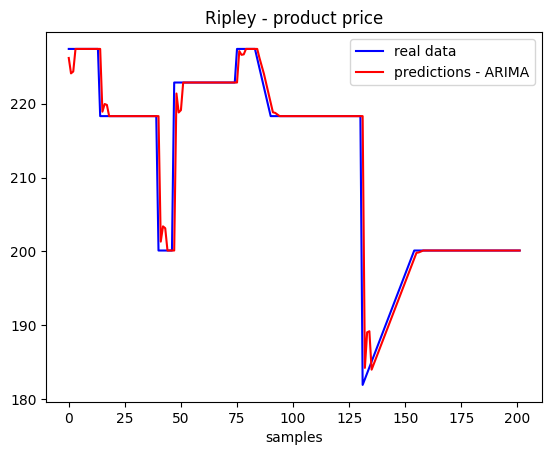

In [36]:
x = [x for x in range(len(test))]

pyplot.plot(x,test, color = 'blue', label='real data')
pyplot.plot(x,predictions, color='red', label='predictions - ARIMA')
pyplot.title("Ripley - product price")
pyplot.xlabel('samples')
pyplot.legend()
pyplot.show()